<a href="https://colab.research.google.com/github/TomohitoFujieda/PoseGeneratorTrainV1/blob/main/TrainPoseGenAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/PoseAI_develop/
!ls

/content/drive/MyDrive/PoseAI_develop
CGAN		   PoseAI_develop.ipynb
generated_pose	   pose_data_for_regression_analysis_2.csv
images		   pose_data_for_regression_analysis_3.csv
images_2	   pose_data_for_regression_analysis.csv
Linear		   pose_data_for_regression_analysis_old2.csv
model_norm	   pose_data_for_regression_analysis_old.csv
model_norm_2	   pose_dataset.csv
model_norm_weight  PoseGenerate.ipynb
models


In [ ]:
import pandas as pd
df = pd.read_csv("pose_dataset.csv", index_col=0)
print(df.columns)

Index(['nose_x', 'nose_y', 'neck_x', 'neck_y', 'right_shoulder_x',
       'right_shoulder_y', 'right_elbow_x', 'right_elbow_y', 'right_hand_x',
       'right_hand_y', 'left_shoulder_x', 'left_shoulder_y', 'left_elbow_x',
       'left_elbow_y', 'left_hand_x', 'left_hand_y', 'right_thigh_x',
       'right_thigh_y', 'right_knee_x', 'right_knee_y', 'right_ankle_x',
       'right_ankle_y', 'left_thigh_x', 'left_thigh_y', 'left_knee_x',
       'left_knee_y', 'left_ankle_x', 'left_ankle_y', 'right_eye_x',
       'right_eye_y', 'left_eye_x', 'left_eye_y', 'right_ear_x', 'right_ear_y',
       'left_ear_x', 'left_ear_y', 'joy', 'sadness', 'excited', 'surprise',
       'anger', 'fear', 'disgust', 'trust'],
      dtype='object')


In [ ]:
keypoint_names = [
    "nose",
    "right_shoulder",
    "left_shoulder",
    "right_thigh",
    "left_thigh",
    "right_elbow",
    "left_elbow",
    "right_hand",
    "left_hand",
    "right_knee",
    "left_knee",
    "right_ankle",
    "left_ankle",
    "right_eye",
    "left_eye",
    "right_ear",
    "left_ear"
]

In [ ]:
CNT = 4

# データセット加工(元座標+感情データ ⇒ 目標座標)

In [ ]:
from torch.utils.data import Subset, Dataset, DataLoader
import torch
import pandas as pd
import torchvision
import torchvision.transforms as transforms

In [ ]:
# TRAIN_DATA_NAME = "pose_data_for_regression_analysis.csv"
TRAIN_DATA_NAME = "./coord_emo_combined/pose_data_" + str(CNT) + ".csv"
POSE_DATA_NAMES = ["frm_x", "frm_y"]
EMOTION_DATA_NAMES = ['joy', 'sadness', 'excited', 'surprise', 'anger', 'fear', 'disgust', 'trust']
POSE_TARGET_NAMES = ["target_x", "target_y"]
LIMB_TYPE = ["limb_type"]
BATCH_SIZE = 10
CUDA_LAUNCH_BLOCKING = 1

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

In [ ]:
# 各特徴点毎に分類したデータセット
class keypoints_dataset(Dataset):
  def __init__(self, limb_type):
    ori_df = pd.read_csv(TRAIN_DATA_NAME)
    df = ori_df[ori_df["limb_type"] == limb_type]       # 特徴点のタイプを記録
    self.frm_keypoint = df[POSE_DATA_NAMES].values      # 推定元となるデータ
    self.emotion = df[EMOTION_DATA_NAMES].values        # 感情データ
    self.target_keypoint = df[POSE_TARGET_NAMES].values # 推定先となるデータ

  def __len__(self):
      return len(self.frm_keypoint)

  def __getitem__(self, index): # 推定元、感情データ、推定先の順で返す
      A = torch.tensor(self.frm_keypoint[index], dtype=torch.float32)
      B = torch.tensor(self.emotion[index], dtype=torch.float32)
      C = torch.tensor(self.target_keypoint[index], dtype=torch.float32)

      return A, B, C

In [ ]:
class StandardScalerSubset(Subset):
    def __init__(self, dataset, indices,
                 emo_mean=None, emo_std=None, eps=10**-9):
        super().__init__(dataset=dataset, indices=indices)
        target_tensor_emo = torch.stack([dataset[i][1] for i in indices])
        target_tensor_emo = target_tensor_emo.to(torch.float32)
        if emo_mean is None:
            self._emo_mean = torch.mean(target_tensor_emo, dim=0)
        else:
            self._emo_mean = emo_mean
        if emo_std is None:
            self._emo_std = torch.std(target_tensor_emo, dim=0, unbiased=False)
        else:
            self._emo_std = emo_std
        self._eps = eps
        self.emo_std.apply_(lambda x: max(x, self.eps))

    def __getitem__(self, idx):
        dataset_list = list(self.dataset[self.indices[idx]])
        input2 = dataset_list[1]
        dataset_list[1] = ((input2 - self.emo_mean) / self.emo_std).to(torch.float32)
        return tuple(dataset_list)

    @property
    def emo_mean(self):
        return self._emo_mean

    @property
    def emo_std(self):
        return self._emo_std

    @property
    def eps(self):
        return self._eps

In [ ]:
datasets = []
for i in range(len(keypoint_names)):
  dataset = keypoints_dataset(i)
  dataset_sss = StandardScalerSubset(dataset, list(range(len(dataset))))
  datasets.append(dataset_sss)

# 学習(元座標+感情データ ⇒ 目標座標)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

In [ ]:
class keypoint_estimator(nn.Module):
  def __init__(self):
    super().__init__()
    self.l = nn.Linear(10, 2)
  def forward(self, frm, emo):
    x = torch.cat([frm, emo], dim=1)
    x = self.l(x)
    return x

In [ ]:
# 学習を行う関数
def train_model(dataset, batch_size, model):
  criterion = nn.MSELoss()                                  # 平均二乗誤差
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # 確率的勾配降下法

  data_loader = DataLoader(dataset, batch_size, shuffle=True)
  loss_history = []

  for epoch in range(100):            # エポック数：100
    total_loss = 0
    for frm, emo, trg in data_loader:
      trg_pred = model(frm, emo)      # 推定
      loss = criterion(trg_pred, trg) # 損失計算

      # 最適化
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
    loss_history.append(total_loss)
    if (epoch + 1) % 10 == 0:
      print('Epoch [{}], Loss: {:.4f}'.format(epoch + 1, total_loss))

  return loss_history

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

def draw_keypoints(canvas, coordinates, name):
  for c in coordinates:
    c_np = c.cpu().detach().numpy().copy()
    c_x = c_np[0][0]
    c_y = c_np[0][1]
    cv2.circle(canvas, (int(c_x), int(c_y)), 4, [255, 255, 255], thickness=-1)
  cv2.imwrite("./images/" + name + ".jpg", canvas)

node: nose
Epoch [10], Loss: 0.3773
Epoch [20], Loss: 0.1935
Epoch [30], Loss: 0.1261
Epoch [40], Loss: 0.0912
Epoch [50], Loss: 0.0680
Epoch [60], Loss: 0.0541
Epoch [70], Loss: 0.0446
Epoch [80], Loss: 0.0380
Epoch [90], Loss: 0.0328
Epoch [100], Loss: 0.0295
node: right_shoulder
Epoch [10], Loss: 0.4521
Epoch [20], Loss: 0.2137
Epoch [30], Loss: 0.1200
Epoch [40], Loss: 0.0762
Epoch [50], Loss: 0.0515
Epoch [60], Loss: 0.0396
Epoch [70], Loss: 0.0324
Epoch [80], Loss: 0.0284
Epoch [90], Loss: 0.0240
Epoch [100], Loss: 0.0218
node: left_shoulder
Epoch [10], Loss: 0.4944
Epoch [20], Loss: 0.2755
Epoch [30], Loss: 0.1700
Epoch [40], Loss: 0.1130
Epoch [50], Loss: 0.0787
Epoch [60], Loss: 0.0598
Epoch [70], Loss: 0.0464
Epoch [80], Loss: 0.0374
Epoch [90], Loss: 0.0308
Epoch [100], Loss: 0.0263
node: right_thigh
Epoch [10], Loss: 1.1230
Epoch [20], Loss: 0.5222
Epoch [30], Loss: 0.2552
Epoch [40], Loss: 0.1321
Epoch [50], Loss: 0.0747
Epoch [60], Loss: 0.0470
Epoch [70], Loss: 0.0324
Ep

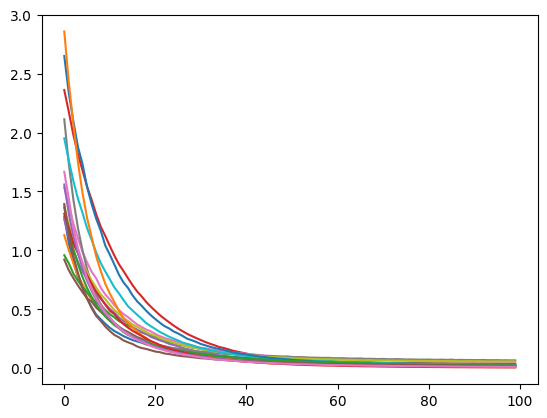

In [ ]:
import matplotlib.pyplot as plt


for k in range(len(keypoint_names)):
  print("node:", keypoint_names[k])
  model = keypoint_estimator()
  loss_history = train_model(datasets[k], 10, model)
  plt.plot(loss_history)

  ori = torch.tensor([[0, 0]], dtype=torch.float32)
  emo_norm = (emo - datasets[k].emo_mean) / datasets[k].emo_std
  cntr = torch.tensor([[256, 128]])
  coordinates = [ori + cntr, model(ori, emo_norm) * 70 + cntr]
  canvas = np.zeros((512, 512), dtype=np.uint8)
  draw_keypoints(canvas, coordinates, keypoint_names[k])

  model_path = "./model_norm_4/model_" + str(CNT) + "/" + keypoint_names[k] + "_est_mdl.pth"
  # model_path = "./model_norm_4/" + keypoint_names[k] + "_est_mdl.pth"
  torch.save(model, model_path)

# 感情データのみからの生成（保留）

## データセット加工(感情データ ⇒ 目標座標) 保留

In [ ]:
from torch.utils.data import Subset, Dataset, DataLoader
import torch
import pandas as pd
import torchvision
import torchvision.transforms as transforms

In [ ]:
TRAIN_DATA_NAME = "pose_data_for_regression_analysis_2.csv"
EMOTION_DATA_NAMES = ['joy', 'sadness', 'excited', 'surprise', 'anger', 'fear', 'disgust', 'trust']
POSE_TARGET_NAMES = ["target_x", "target_y"]
LIMB_TYPE = ["limb_type"]
BATCH_SIZE = 10
CUDA_LAUNCH_BLOCKING = 1

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

In [ ]:
class keypoints_dataset(Dataset):
  def __init__(self, limb_type):
    ori_df = pd.read_csv(TRAIN_DATA_NAME)
    df = ori_df[ori_df["limb_type"] == limb_type]
    self.emotion = df[EMOTION_DATA_NAMES].values
    self.target_keypoint = df[POSE_TARGET_NAMES].values

  def __len__(self):
      return len(self.emotion)

  def __getitem__(self, index):
      A = torch.tensor(self.emotion[index], dtype=torch.float32)
      B = torch.tensor(self.target_keypoint[index], dtype=torch.float32)

      return A, B

In [ ]:
class StandardScalerSubset(Subset):
    def __init__(self, dataset, indices,
                 emo_mean=None, emo_std=None, eps=10**-9):
        super().__init__(dataset=dataset, indices=indices)
        target_tensor_emo = torch.stack([dataset[i][1] for i in indices])
        target_tensor_emo = target_tensor_emo.to(torch.float32)
        if emo_mean is None:
            self._emo_mean = torch.mean(target_tensor_emo, dim=0)
        else:
            self._emo_mean = emo_mean
        if emo_std is None:
            self._emo_std = torch.std(target_tensor_emo, dim=0, unbiased=False)
        else:
            self._emo_std = emo_std
        self._eps = eps
        self.emo_std.apply_(lambda x: max(x, self.eps))

    def __getitem__(self, idx):
        dataset_list = list(self.dataset[self.indices[idx]])
        input2 = dataset_list[1]
        dataset_list[1] = ((input2 - self.emo_mean) / self.emo_std).to(torch.float32)
        return tuple(dataset_list)

    @property
    def emo_mean(self):
        return self._emo_mean

    @property
    def emo_std(self):
        return self._emo_std

    @property
    def eps(self):
        return self._eps

In [ ]:
datasets = []
for i in range(len(keypoint_names)):
  dataset = keypoints_dataset(i)
  datasets.append(dataset)

## 学習(感情データ ⇒ 目標座標) 保留

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

In [ ]:
class keypoint_estimator(nn.Module):
  def __init__(self):
    super().__init__()
    self.l = nn.Linear(8, 2)
  def forward(self, emo):
    # x = torch.cat([frm, emo], dim=1)
    x = self.l(emo)
    return x

In [ ]:
def train_model(dataset, batch_size, model):
  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

  data_loader = DataLoader(dataset, batch_size, shuffle=True)
  loss_history = []

  for epoch in range(100):
    total_loss = 0
    for emo, trg in data_loader:
      trg_pred = model(emo)
      loss = criterion(trg_pred, trg)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
    loss_history.append(total_loss)
    if (epoch + 1) % 10 == 0:
      print('Epoch [{}], Loss: {:.4f}'.format(epoch + 1, total_loss))

  return loss_history

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

def draw_keypoints(canvas, coordinates, name):
  for c in coordinates:
    c_np = c.cpu().detach().numpy().copy()
    c_x = c_np[0][0]
    c_y = c_np[0][1]
    cv2.circle(canvas, (int(c_x), int(c_y)), 4, [255, 255, 255], thickness=-1)
  cv2.imwrite("./images_2_/" + name + ".jpg", canvas)

Epoch [10], Loss: 0.3899
Epoch [20], Loss: 0.2589
Epoch [30], Loss: 0.2036
Epoch [40], Loss: 0.1755
Epoch [50], Loss: 0.1563
Epoch [60], Loss: 0.1400
Epoch [70], Loss: 0.1278
Epoch [80], Loss: 0.1182
Epoch [90], Loss: 0.1080
Epoch [100], Loss: 0.1005
Epoch [10], Loss: 0.5074
Epoch [20], Loss: 0.1802
Epoch [30], Loss: 0.0872
Epoch [40], Loss: 0.0562
Epoch [50], Loss: 0.0443
Epoch [60], Loss: 0.0386
Epoch [70], Loss: 0.0343
Epoch [80], Loss: 0.0309
Epoch [90], Loss: 0.0280
Epoch [100], Loss: 0.0260
Epoch [10], Loss: 0.3523
Epoch [20], Loss: 0.1727
Epoch [30], Loss: 0.1153
Epoch [40], Loss: 0.0911
Epoch [50], Loss: 0.0798
Epoch [60], Loss: 0.0716
Epoch [70], Loss: 0.0644
Epoch [80], Loss: 0.0593
Epoch [90], Loss: 0.0539
Epoch [100], Loss: 0.0505
Epoch [10], Loss: 0.6504
Epoch [20], Loss: 0.2694
Epoch [30], Loss: 0.1559
Epoch [40], Loss: 0.1218
Epoch [50], Loss: 0.1098
Epoch [60], Loss: 0.1029
Epoch [70], Loss: 0.0949
Epoch [80], Loss: 0.0906
Epoch [90], Loss: 0.0861
Epoch [100], Loss: 0.0

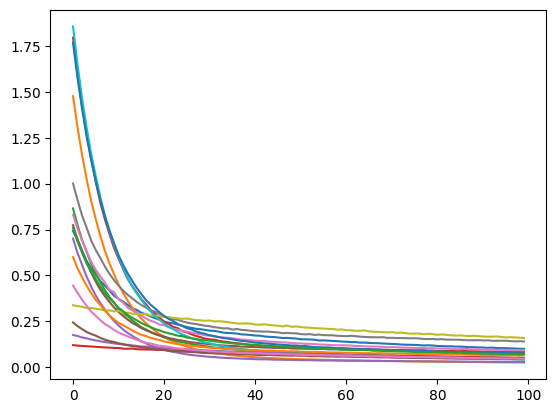

In [ ]:
import matplotlib.pyplot as plt

emo = (torch.tensor([[2, 1, 3, 2, 1, 1, 1, 4]], dtype=torch.float32) - 1) / 3

for k in range(len(keypoint_names)):
  model = keypoint_estimator()
  loss_history = train_model(datasets[k], 10, model)
  plt.plot(loss_history)

  cntr = torch.tensor([[256, 256]])
  coordinates = [ori + cntr, model(emo) * 70 + cntr]
  canvas = np.zeros((512, 512), dtype=np.uint8)
  draw_keypoints(canvas, coordinates, keypoint_names[k])

  model_path = "./model_norm_2/" + keypoint_names[k] + "_est_mdl.pth"
  torch.save(model, model_path)